In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# Example 1. MNIST

Trains a fully connected neural network to identify handwritten digits using MNIST dataset.

## 1. Setup

Imports and defines the objects needed for this example.

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import itertools

from deeptrack.features import LoadImage, Lambda, ConditionalSetFeature
from deeptrack.augmentations import FlipLR, FlipUD, FlipDiagonal, Crop, PreLoad
from deeptrack.models import UNet
from deeptrack.generators import Generator

PATH_TO_DATASET = os.path.abspath("./datasets/malaria")

TRAINING_SET_CONF = json.load(
    open(os.path.join(PATH_TO_DATASET, "training_config.json"))
)

VALIDATION_SET_CONF = json.load(
    open(os.path.join(PATH_TO_DATASET, "training_config.json"))
)

Using TensorFlow backend.


## 2. Defining the dataset

### 2.1 Defining the training data

The dataset is how we provide the network with training data. For this example we create the dataset by loading it from storage using `LoadImage`.

We want to distinguish the training set and the validation set. There are several ways to accomplish this, but here we use pass a property config that defends on the argument `validation`, which determines from which dataset to load images from. The value of validation is `None` by default, but can be set by passing a value when calling `.update()`. 

In [3]:
training_iterator = itertools.cycle(TRAINING_SET_CONF)
validation_iterator = itertools.cycle(VALIDATION_SET_CONF)

load_training = LoadImage(
    config_iterator=lambda validation: validation_iterator if validation else training_iterator,
    config_object=lambda config_iterator: next(config_iterator),
    path=lambda config_object: config_object["image"]["pathname"] 
) 

normalization = Lambda(lambda: lambda image: image / 256)

normalized_image = load_training + normalization

We define a feature for loading the mask.

In [4]:
load_mask = LoadImage(
    config_object = lambda: load_training.config_object,
    path = lambda config_object: config_object["mask"]["pathname"] 
)

Some cells are not annoted along the edges, so we crop that region out.

In [5]:
crop_edges = Crop(
    [normalized_image, load_mask],
    corner=(32, 32),
    crop_size=(-64, -64),
    load_size=1,
    updates_per_reload=1
)

The training images are augmented.

In [6]:
cropped_images = Crop(
    crop_edges,
    crop_size=(256, 256),
    updates_per_reload=4
)

training_dataset = FlipLR(FlipUD(FlipDiagonal(cropped_images)))

data_shuffling = PreLoad(
    training_dataset,
    load_size=256,
    updates_per_reload=256,
    order=lambda load_size, number_of_updates, order: order if number_of_updates else np.random.permutation(load_size),
    index=lambda number_of_updates, order: order[number_of_updates]
)

In [7]:
dataset = ConditionalSetFeature(
    condition="is_validating",
    is_validating=lambda validation: validation,
    on_false=data_shuffling,
    on_true=crop_edges
)

### 2.2 Defining the training labels

Labels are created similarly. We load the labels using `LoadImage`, and use `ConditionalSetProperty` to conditionally set where to load the labels from.

In [8]:
# Load labels from storage
def get_image(image):
    I = image[0]
    return I[:(I.shape[0]//8)*8, :(I.shape[1]//8)*8]

def get_label(image):
    I = image[1]
    return I[:(I.shape[0]//8)*8, :(I.shape[1]//8)*8]

### 2.3 Visualizing the dataset

To ensure the data and the labels match up we plot 8 images print their correspoding label. To convert the objects we created to an numpy array, we call the method `resolve()`. Since we flattened the images we need to reshape the images again to visualize them.

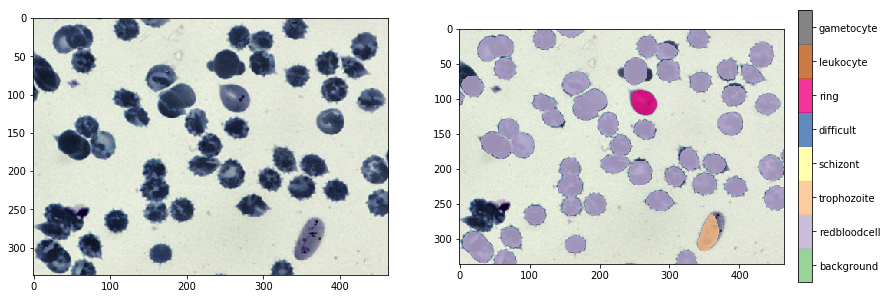

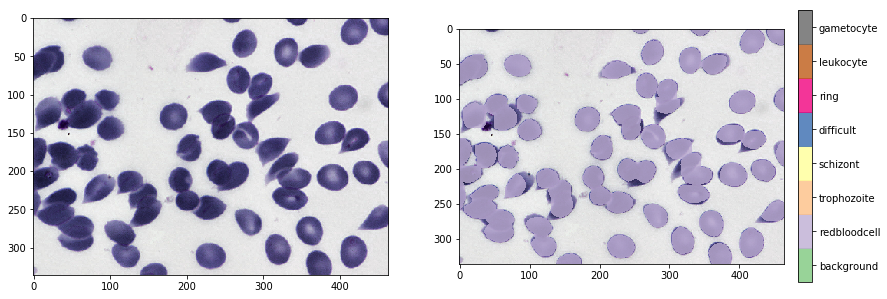

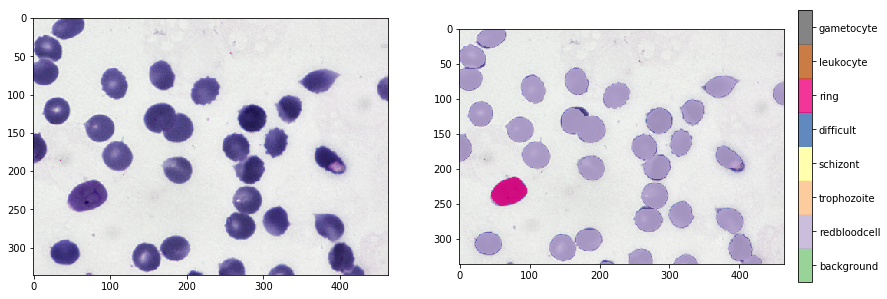

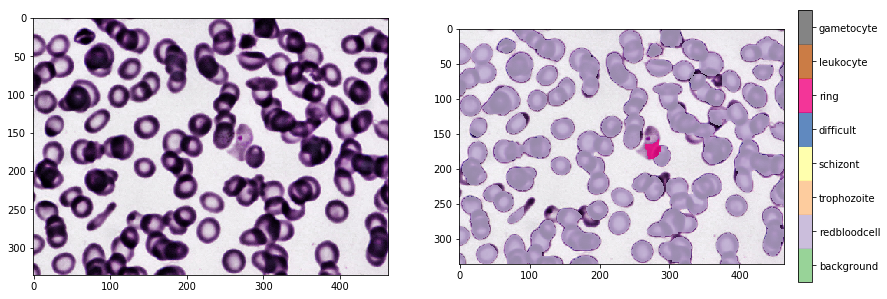

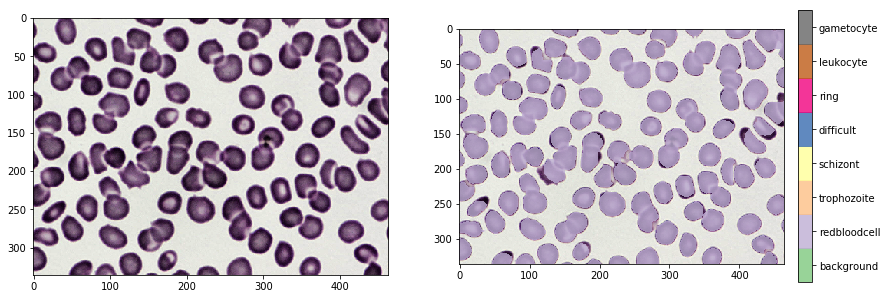

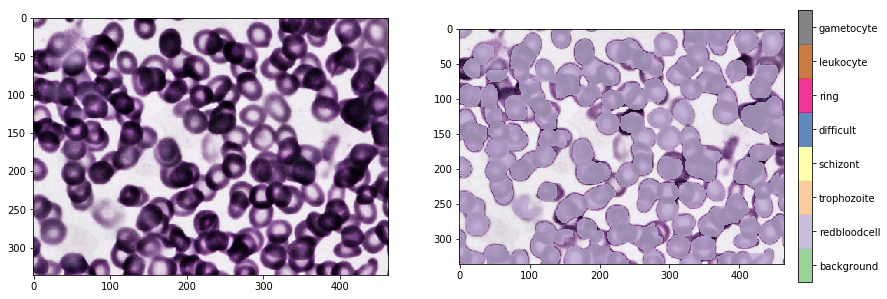

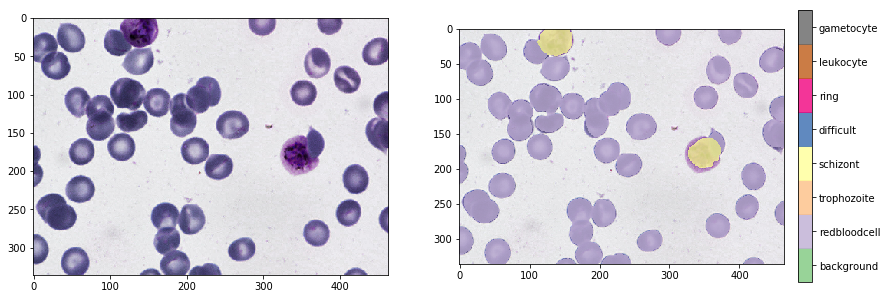

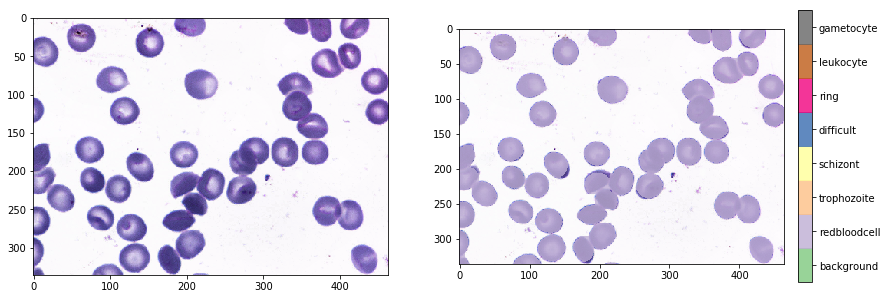

In [9]:
import tensorflow.keras.utils as utils

labels = ["background", "redbloodcell", "trophozoite", "schizont", "difficult", "ring", "leukocyte", "gametocyte"]

NUMBER_OF_IMAGES = 8
class_weight = 0
for image_index in range(NUMBER_OF_IMAGES):
    image_label_tuple = dataset.update(validation=True).resolve()
    image = get_image(image_label_tuple)
    mask = get_label(image_label_tuple)
    mask = np.ma.masked_where(mask == 0, mask)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(mask[:, :, 0], cmap="Accent", vmin=0, vmax=8, alpha=0.8)
    ax = plt.colorbar(fraction=0.046, pad=0.04)
    ax.set_ticks(np.arange(0,8) + 0.5)
    ax.set_ticklabels(labels)

## 3. Defining the network

The network used is a fully connected neural network. Here we define the network architecture, loss function and the optimizer.

In [10]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

eps = 1e-6

class_weight = np.array([[[[1.5, 3.5, 60, 300, 300, 300, 300, 300]]]])

def softmax_categorical(T, P):
    labels_one_hot = K.one_hot(K.cast(K.squeeze(T, axis=-1), "uint8"), 8)
    pixelwise_weight = K.cast_to_floatx(T != 4)
#     class_weight = 1/(K.mean(labels_one_hot, axis=(0,1,2), keepdims=True) + 1e-3)
    true_error = K.mean(labels_one_hot * K.log(P + eps) * class_weight * pixelwise_weight, axis=-1)
    return -K.mean(true_error)

model = UNet(
    input_shape=(None, None, 3),
    number_of_outputs=8,
    steps_per_pooling=2,
    dropout=(0.25, 0.25, 0.25, 0.25),
    output_activation="softmax",
    loss=softmax_categorical,
    optimizer="sgd"
)

model.load_weights("CellCategorization.h5")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 1 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
spatial_dropout2d_1 (SpatialDro (None, None, None, 1 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

## 4. Training the network

The network is trained for 100 epochs using standard Keras syntax.

By passing the argument `validation=True` to `resolve` we toggle `ConditionalSetProperty` to load from the validation files instead.

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

generator = Generator().generate(dataset, get_label, get_image, batch_size=32)

validation_set = [dataset.update(validation=True).resolve() for _ in range(len(VALIDATION_SET_CONF))]
validation_data = [get_image(v_tuple) for v_tuple in validation_set]
validation_labels = [get_label(v_tuple) for v_tuple in validation_set]

# model.compile(loss=softmax_categorical, optimizer=Adam(amsgrad=True, lr=0.005))


# h = model.fit(
#     generator,
#     epochs=1000,
#     steps_per_epoch=len(TRAINING_SET_CONFIG)
#     validation_data=(
#         np.array(validation_data),
#         np.array(validation_labels)
#     ),
#     callbacks=[
#         EarlyStopping(patience=30, restore_best_weights=True, verbose=1),
#         ReduceLROnPlateau(min_lr=1e5, factor=0.3, patience=5, verbose=1)
#     ]
# )

## 5. Evaluating the training

### 5.1 Loss vs validation
We plot the metrics evaluated on the training data compared to the validation data to spot potential overtraining. 

In [15]:
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.show()

NameError: name 'h' is not defined

### 5.2 Prediction vs actual

We show a few images, the true digit and the predicted digit

In [15]:
NUMBER_OF_IMAGES = 32

# validation_prediction = model.predict(np.array(validation_data))

from scipy.io import savemat


savemat("../../figures/cellcategorization_prediction.mat", {
    "prediction": np.array(np.argmax(validation_prediction, axis=-1), dtype=np.uint8),
    "data": np.array(np.array(validation_data) * 255, dtype=np.uint8),
    "labels": np.array(validation_labels, dtype=np.uint8),
})

print(np.array(np.array(validation_data) * 255, dtype=np.uint8).shape)
# for image, mask, prediction, _ in zip(validation_data, 
#                                      validation_labels,
#                                      validation_prediction,
#                                      range(NUMBER_OF_IMAGES)):
    
    
#     mask = np.ma.masked_where(mask == 0, mask)
#     prediction_mask = np.argmax(prediction, axis=-1)
#     prediction_mask = np.ma.masked_where(prediction_mask == 0, prediction_mask)
    
    
#     plt.figure(figsize=(14, 5))
#     plt.subplot(1, 3, 1)
#     plt.imshow(image)
    
#     plt.subplot(1, 3, 2)
#     plt.imshow(image)
#     plt.imshow(mask[:, :, 0], cmap="Accent", vmin=0, vmax=8, alpha=0.8)
    
#     plt.subplot(1, 3, 3)
#     plt.imshow(image)
#     plt.imshow(prediction_mask, cmap="Accent", vmin=0, vmax=8, alpha=0.8)
    
#     ax = plt.colorbar(fraction=0.046, pad=0.04)
#     ax.set_ticks(np.arange(0,8) + 0.5)
#     ax.set_ticklabels(labels)
#     plt.show()

(1208, 336, 464, 3)
